In [1]:
import os
import jax

from evojax import Trainer
from evojax.task.goal import Goal
from evojax.policy import MLPPolicy
from evojax.algo import PGPE
from evojax import util

In [2]:
log_dir = './log/goal_notebook'
if not os.path.exists(log_dir):
    os.makedirs(log_dir, exist_ok=True)
logger = util.create_logger(
    name='Goal-Notebook', log_dir=log_dir, debug=False)

logger.info('EvoJAX Goal (Notebook) Demo')
logger.info('=' * 30)

Goal-Notebook: 2022-04-07 20:45:38,811 [INFO] EvoJAX Goal (Notebook) Demo
Goal-Notebook: 2022-04-07 20:45:38,811 [INFO] ==============================


In [3]:
seed = 42

train_task = Goal(test=False, harder=False)
test_task = Goal(test=True, harder=False)

policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[60, 60],
    output_dim=train_task.act_shape[0],
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    logger=logger,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()



absl: 2022-04-07 20:45:41,818 [INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
absl: 2022-04-07 20:45:41,819 [INFO] Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
absl: 2022-04-07 20:45:41,820 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
absl: 2022-04-07 20:45:41,821 [WARNING] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
MLPPolicy: 2022-04-07 20:45:42,716 [INFO] MLPPolicy.num_params = 4322
Goal-Notebook: 2022-04-07 20:45:42,738 [INFO] Start to train for 150 iterations.
Goal-Notebook: 2022-04-07 20:45:49,495 [INFO] Iter=10, size=64, max=0.6969, avg=0.5221, min=0.3789, std=0.0714
Goal-Notebook: 2022-04-07 20:45:53,461 [INFO] Iter=20, size=64, max=0.7240, avg=0.5997, min=0.4461, std=0.0665
Goal-Notebook: 2022-04-07 20:45:57,423 [INFO] It

reward=[1.7212903]
reward=[1.3545533]


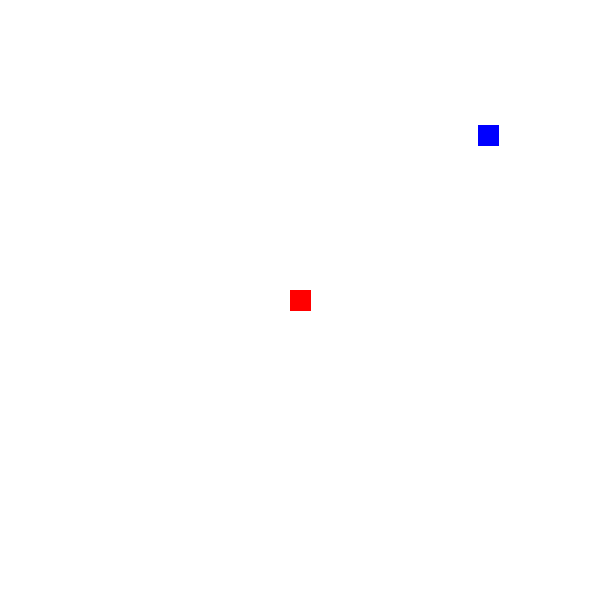

In [4]:
# Let's visualize the learned policy.
from IPython.display import Image as DisplayImage

def render(task, algo, policy):
    """Render the learned policy."""

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = []
    for _ in range(2):
        images.append(Goal.render(task_s, 0))
        done = False 
        step = 0
        reward = 0
        while not done:
            act, policy_s = act_fn(task_s, params, policy_s)
            task_s, r, done = step_fn(task_s, act)
            step += 1
            reward = reward + r
            images.append(Goal.render(task_s, 0))
        print('reward={}'.format(reward))
        
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=20, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'goal.gif')
DisplayImage('goal.gif', format='png')